
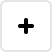
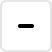
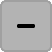
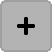
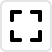
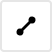
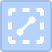

In [1]:
import numpy as np
import pandas as pd

from lets_plot import *
from lets_plot.mapping import as_discrete
LetsPlot.setup_html()

## Test datasets

In [2]:
iris_df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/master/data/iris.csv")

iris_df.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [3]:
def construct_violin_df(df, xname, yname, n=512):
    from functools import reduce

    from scipy.stats import gaussian_kde

    def get_weights(values):
        def nrd0_bw(kde):
            iqr = np.quantile(kde.dataset, .75) - np.quantile(kde.dataset, .25)
            std = np.std(kde.dataset)
            size = kde.dataset.size
            if iqr > 0:
                return .9 * min(std, iqr / 1.34) * (size ** -.2)
            if std > 0:
                return .9 * std * (size ** -.2)

        yrange = np.linspace(values.min(), values.max(), n)

        return {yname: yrange, 'weight': gaussian_kde(values, bw_method=nrd0_bw)(yrange)}

    def reducer(agg_df, xval):
        weights = get_weights(df[df[xname] == xval][yname])
        y = weights[yname]
        x = [xval] * y.size
        w = weights['weight']

        return pd.concat([agg_df, pd.DataFrame({xname: x, yname: y, 'weight': w})], ignore_index=True)

    return reduce(reducer, df[xname], pd.DataFrame(columns=[xname, yname, 'weight']))

violin_df = construct_violin_df(iris_df, 'species', 'sepal_length')
violin_df.head()

species  sepal_length    weight
0  setosa      4.300000  0.222676
1  setosa      4.302935  0.228662
2  setosa      4.305871  0.234639
3  setosa      4.308806  0.240684
4  setosa      4.311742  0.246886

In [4]:
size = 100
np.random.seed(42)
random_df = pd.DataFrame({
    'v': np.random.normal(size=size),
    'c1': np.random.choice(['A', 'B', 'C'], size=size),
    'c2': np.random.choice(['a', 'b'], size=size)
})

random_df.head()

v c1 c2
0  0.496714  A  b
1 -0.138264  B  b
2  0.647689  A  a
3  1.523030  A  a
4 -0.234153  C  a

In [5]:
def mask(p=.1, seed=42):
    np.random.seed(seed)
    return np.random.choice([True, False], random_df.shape[0], p=[p, 1 - p])

nullable_df = random_df.copy()
nullable_df.loc[mask(seed=1), 'v'] = np.nan
nullable_df.loc[mask(seed=2), 'c1'] = np.nan
nullable_df.loc[mask(seed=6), 'c2'] = np.nan

nullable_df.head()

v   c1   c2
0  0.496714    A    b
1 -0.138264  NaN    b
2       NaN    A    a
3  1.523030    A  NaN
4 -0.234153    C    a

## Minimalistic example

In [6]:
ggplot(random_df, aes(y='v')) + geom_violin() + ggtitle("Simplest example")

## Comparison of geoms

In [7]:
p_d = ggplot(iris_df) + \
    geom_density(aes(x='sepal_length', fill='species'), color='black', alpha=.7) + \
    facet_grid(x='species') + \
    coord_flip() + \
    ggtitle("geom_density()")
p_v = ggplot(iris_df, aes('species', 'sepal_length')) + \
    geom_violin(aes(fill='species'), alpha=.7) + \
    ggtitle("geom_violin()")

w, h = 400, 300
bunch = GGBunch()
bunch.add_plot(p_d, 0, 0, w, h)
bunch.add_plot(p_v, w, 0, w, h)
bunch.show()

## Custom density parameters

In [8]:
p = ggplot(iris_df, aes('species', 'sepal_length'))
p_default = p + geom_violin() + ggtitle("Default")
p_kernel = p + geom_violin(kernel='epanechikov') + ggtitle("kernel='epanechikov'")
p_bw = p + geom_violin(bw=.1) + ggtitle("bw=0.1")
p_adjust = p + geom_violin(adjust=2) + ggtitle("adjust=2")

w, h = 400, 300
bunch = GGBunch()
bunch.add_plot(p_default, 0, 0, w, h)
bunch.add_plot(p_kernel, w, 0, w, h)
bunch.add_plot(p_bw, 0, h, w, h)
bunch.add_plot(p_adjust, w, h, w, h)
bunch.show()

## Grouping and tooltips

In [9]:
ggplot(random_df, aes(x='c1', y='v')) + \
    geom_violin(aes(fill='c2'), tooltips=layer_tooltips().line('^x')
                                                         .line('category|@c2')
                                                         .line('v|@v')
                                                         .line('@|@..density..')
                                                         .line('count|@..count..')
                                                         .line('scaled|@..scaled..')) + \
    ggtitle("Grouping and tooltips")

## `coord_flip()`

In [10]:
ggplot(iris_df, aes('species', 'sepal_length')) + \
    geom_violin() + \
    coord_flip() + \
    ggtitle("Use coord_flip()")

## "identity" statistic

In [11]:
ggplot(violin_df, aes('species', 'sepal_length')) + \
    geom_violin(aes(weight='weight'), stat='identity') + \
    ggtitle("Use 'identity' statistic")

## Additional layers

In [12]:
ggplot(random_df, aes(as_discrete('c1', order=-1), 'v')) + \
    geom_violin(aes(color='c1', fill='c1'), alpha=.5, size=2, \
                sampling=sampling_group_systematic(2)) + \
    facet_grid(x='c2') + \
    scale_y_continuous(breaks=list(np.linspace(-3, 3, 9))) + \
    scale_color_brewer(type='qual', palette='Set1') + \
    scale_fill_brewer(type='qual', palette='Set1') + \
    ylim(-3, 3) + \
    coord_fixed(ratio=.5) + \
    theme_grey() + \
    ggtitle("Some additional aesthetics, parameters and layers")

## Dataset with NaN's

In [13]:
ggplot(nullable_df, aes('c1', 'v')) + geom_violin()